# Anomaly Detection using unsupervised learning

By using unsupervised learning, this notebook code creates clusters and determines optimum centroids. The dataset used here is generated using sklearn APIs. scikit learn k-means model is used to cluster the datapoints in the dataset. The trained model is used to predict the anomaly and any datapoint away from 75 percentile point from the centroid is considered anomaly.

In [1]:
#import all the libraries we would be uisng in this notebook
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import pandas as pd
from sklearn.cluster import KMeans

#save model using joblib directory
import joblib

from scipy.spatial import distance

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
#Read the dataset
data = pd.read_csv('data/generated.csv')

In [3]:
data.head()

,Column1,Column2
0,10.283516,-6.053867
1,10.021650,-8.175668
2,2.703810,-1.249264
3,2.139334,0.558977
4,11.513920,-4.542781


In [4]:
data.shape

(7000, 2)

In [5]:
# Function to plot the scatter plots
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

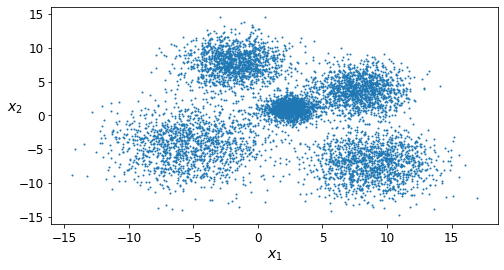

In [6]:
X = data[["Column1","Column2"]].to_numpy()
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [7]:
#Train and predict
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [8]:
# predicted clusters for each datapoint
y_pred

array([2, 2, 4, ..., 4, 1, 0], dtype=int32)

In [9]:
#Centorids for each clusters
kmeans.cluster_centers_

array([[-5.60209425, -4.70002596],
       [ 8.00341833,  3.83454254],
       [ 8.86392199, -7.2454192 ],
       [-1.86957793,  7.83087273],
       [ 2.39354513,  0.84304386]])

In [10]:
#Plot the clusters and centroids
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

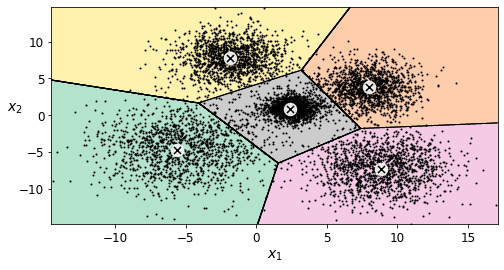

In [11]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [12]:
#Use model to predict a random datapoint and see which cluster it belongs to
pt2 = np.array([[5.7, 5.7]])
cluster_id = kmeans.predict(pt2)
cluster_id[0]

1

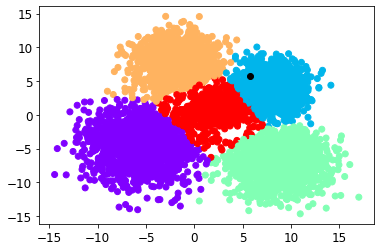

In [13]:
# Plot this new data point ( in slightly different graph)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(pt2[:,0],pt2[:,1],  color='black')

Model is now trained and we have distributed the dataset into clustres
Using following logic let us find out anomolies now.
 1. Calculate euclidean distance of each datapoint in the cluster from the centroid of the cluster
 2. I have decided to mark any datapoint which is farther than 75 percentile number from the centroid. So my threshold to mark a datapoint as anomaly is 75 percentile. But this could be any other criteria of your choice or as suitable for your usecase.
 3. Now determine 75 percentile value for each cluster
 4. Find the cluster where new datapoint belongs to, by calling predict()
 5. Calculate the euclidean distance of the new data point from its cluster centroid
 6. Compare it with 75 percentile value of the corresponding cluster
 7. Mark the datapoint as anomaly if its beyond threshold 

In [14]:
#Write a class to hold the metadata used in anomaly detection
from scipy.spatial import distance
class AnomalyDetector:
    centroids=[]
    thresholds=[]
    
    
    
    def isAnomaly(self, datapoint, centroidId):
        centroid = self.centroids[centroidId]
        threshold = self.thresholds[centroidId]
        dist = distance.euclidean(centroid, datapoint)
        return (dist > threshold)
    
    def initData(self, centroids_list, thresholds_list):
        self.centroids = centroids_list
        self.thresholds = thresholds_list

In [15]:
# calculate all the thresholds considering 75 percentile as cutoff
def getAllThresholds(X1, model):
    thresholdsarr = []
    for centroid_index in range(model.cluster_centers_.shape[0]):
        cluster_labels = np.where(model.labels_ == centroid_index)[0]
        dtpt = []
        centroid = model.cluster_centers_[centroid_index]
        for lable in cluster_labels:
            dtpt.append( distance.euclidean(centroid, X1[lable]))
            
        thresholdsarr.append(np.percentile(dtpt, 75))
    return (thresholdsarr)

In [16]:
#list of thresholds for corresponding cluster ids
thresholds_list = getAllThresholds(X, kmeans)
thresholds_list

[4.554472718677509,
 2.990373939710921,
 3.9786807099369565,
 3.271334955097146,
 1.9609802097810594]

In [17]:
#list of centroids for each cluster
centroid_list = kmeans.cluster_centers_
centroid_list

array([[-5.60209425, -4.70002596],
       [ 8.00341833,  3.83454254],
       [ 8.86392199, -7.2454192 ],
       [-1.86957793,  7.83087273],
       [ 2.39354513,  0.84304386]])

In [18]:
# Create the object for the class and init the params
anomalyDetector = AnomalyDetector()

In [19]:
anomalyDetector.initData(centroid_list, thresholds_list)

In [20]:
#predict and find the anomaly
datapoint = np.array([[-10.60209425, 10.70002596 ]])
new_prediction = kmeans.predict(datapoint)
inference = anomalyDetector.isAnomaly(datapoint, new_prediction[0])

In [21]:
inference

True